# Recurrent Neural Networks Models
In this notebook, we show an example of how RNNs can be used with darts.
If you are new to darts, we recommend you first follow the `darts-intro.ipynb` notebook.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.preprocessing import ScalerWrapper
from darts.models import RNNModel, ExponentialSmoothing
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

### Some hyper-parameters:

In [3]:
# Number of previous time stamps taken into account.
SEQ_LENGTH = 12
# Number of features in last hidden state
HIDDEN_SIZE = 25
# number of output time-steps to predict
OUTPUT_LEN = 1
# Number of stacked rnn layers.
NUM_LAYERS = 1

## Air Passenger Example

In [4]:
# Read data:
df = pd.read_csv('AirPassengers.csv', delimiter=",")
series = TimeSeries.from_dataframe(df, 'Month', '#Passengers')

# Create training and validation sets:
train, val = series.split_after(pd.Timestamp('19590101'))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = ScalerWrapper()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

Let's train an LSTM neural net. For using vanilla RNN or GRU instead, replace `'LSTM'` by `'RNN'` or `'GRU'`, respectively.

In [5]:
my_model = RNNModel('LSTM', OUTPUT_LEN, SEQ_LENGTH, HIDDEN_SIZE, NUM_LAYERS, 
                    batch_size=16, n_epochs=400, optimizer_kwargs={'lr': 1e-3}, 
                    model_name='Air_RNN', log_tensorboard=True)

In [6]:
my_model.fit(train_transformed, val_transformed, verbose=True)  # 107

Training loss: 0.0068, validation loss: 0.0431


### Look at predictions on the validation set
Use the "current" model - i.e., the model at the end of the training procedure:

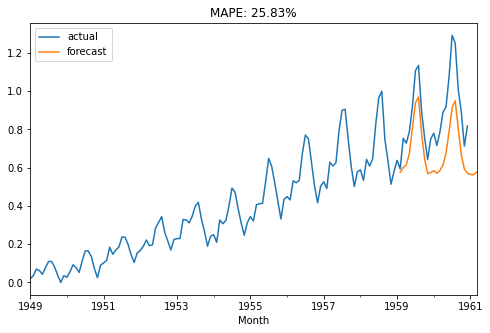

In [7]:
def eval_model(model):
    pred_series = model.predict(n=26)
    plt.figure(figsize=(8,5))
    series_transformed.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_transformed)))
    plt.legend();
    
eval_model(my_model)

Use the best model obtained over training, according to validation loss:

loading model_best_250.pth.tar


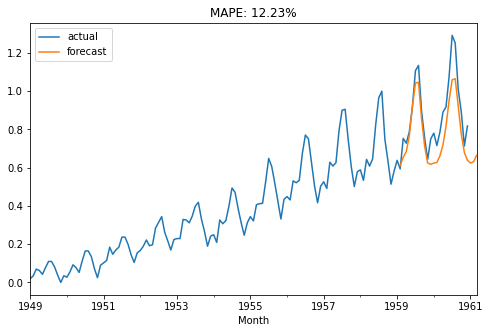

In [8]:
best_model = RNNModel.load_from_checkpoint(model_name='Air_RNN', best=True)
eval_model(best_model)

### Backtesting
Let's backtest an `RNN` model, with a forecast horizon of 6 months:

In [9]:
from darts.backtesting import backtest_forecasting

my_model = RNNModel('RNN', OUTPUT_LEN, SEQ_LENGTH, HIDDEN_SIZE, NUM_LAYERS, 
                    batch_size=32, n_epochs=200, optimizer_kwargs={'lr': 1e-3}, 
                    model_name='Air_RNN')

# Perform the actual backtest
backtest_series = backtest_forecasting(series_transformed, my_model, pd.Timestamp('19590101'), 
                                       fcast_horizon_n=6, verbose=True)

MAPE: 7.96%


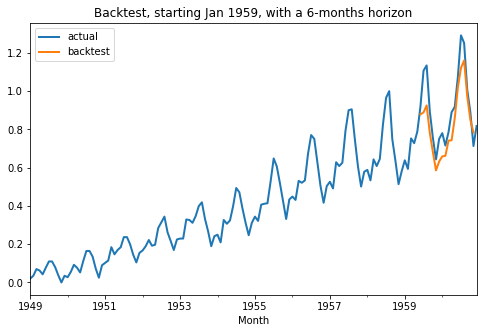

In [10]:
plt.figure(figsize=(8,5))
series_transformed.plot(label='actual', lw=2)
backtest_series.plot(label='backtest', lw=2)
plt.legend()
plt.title('Backtest, starting Jan 1959, with a 6-months horizon');
print('MAPE: {:.2f}%'.format(mape(transformer.inverse_transform(series_transformed), 
                                 transformer.inverse_transform(backtest_series))))

### Trials with a longer output length

In [11]:
my_model_gru = RNNModel('GRU', OUTPUT_LEN*4, SEQ_LENGTH, HIDDEN_SIZE, NUM_LAYERS,
                        batch_size=64, n_epochs=1500, model_name='Air_GRU_out12', log_tensorboard=True)

In [12]:
my_model_gru.fit(train_transformed, val_series=val_transformed, verbose=True)

Training loss: 0.0099, validation loss: 0.0520


Result of training

Test with horizon=28, and feeding predictions

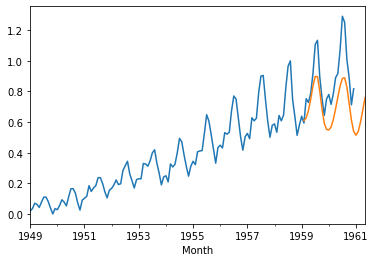

In [13]:
pred_series = my_model_gru.predict(n=28)
series_transformed.plot()
pred_series.plot()

## Monthly sunspot
Let's now try a more challenging time series; that of the monthly number of sunspots since 1749. First, we build the time series from the data, and check its periodicity.

(True, 125)

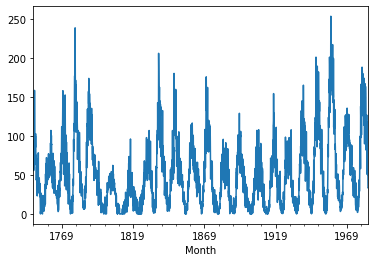

In [14]:
df2 = pd.read_csv('monthly-sunspots.csv', delimiter=",")
series_sunspot = TimeSeries.from_dataframe(df2, 'Month', 'Sunspots')

series_sunspot.plot()
check_seasonality(series_sunspot, max_lag=240)

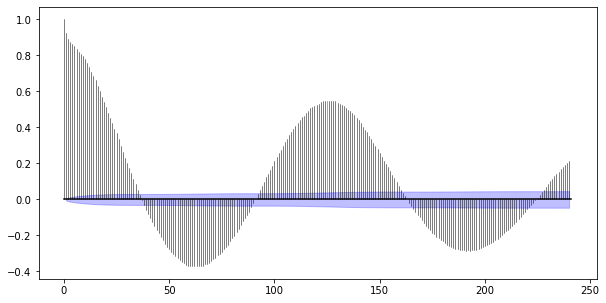

In [15]:
plot_acf(series_sunspot, 125, max_lag=240) # ~11 years seasonality

In [16]:
train_sp, val_sp = series_sunspot.split_after(pd.Timestamp('19401001'))

transformer_sunspot = ScalerWrapper()
train_sp_transformed = transformer_sunspot.fit_transform(train_sp)
val_sp_transformed = transformer_sunspot.transform(val_sp)
series_sp_transformed = transformer.transform(series_sunspot)

In [17]:
SEQ_LENGTH = 125
HIDDEN_SIZE = 10
OUTPUT_LEN = 10
NUM_LAYERS = 1

In [18]:
my_model_sun = RNNModel('RNN', OUTPUT_LEN, SEQ_LENGTH, HIDDEN_SIZE, NUM_LAYERS,
                        batch_size=64, n_epochs=300, model_name='sun_GRU', nr_epochs_val_period=1,
                        optimizer_kwargs={'lr': 1e-3}, log_tensorboard=True)

my_model_sun.fit(train_sp_transformed, val_series=val_sp_transformed, verbose=True)

Training loss: 0.0154, validation loss: 0.0172


For the sake of comparison, let's also fit an exponential smoothing model:

In [19]:
my_model_ets = ExponentialSmoothing()
my_model_ets.fit(train_sp_transformed)

In [20]:
# Compute the predictions with the two models (the RNN can be somewhat slow)
pred_series = my_model_sun.predict(550)
pred_series_ets = my_model_ets.predict(550)

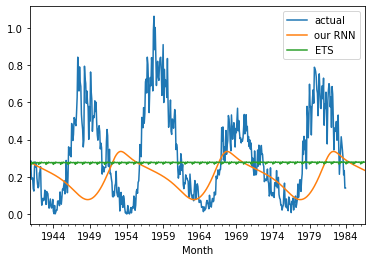

In [21]:
val_sp_transformed.plot(label='actual')
pred_series.plot(label='our RNN')
pred_series_ets.plot(label='ETS')
plt.legend();